<a href="https://colab.research.google.com/github/coryroyce/code_assignments/blob/main/211124_Approximate_Nearest_Neighbor_Search/Approximate_Nearest_Neighbors_Cory_Randolph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Approximate Nearest Neighbors
Cory Randolph

11/21/2021

Goal: Demonstrate several different Approximate Nearest Neighbors Algorithms on letter images.



# Load Packages

Install needed packages for this project

In [381]:
# Install the emnist package for loading image data easily
!pip install emnist
!pip install umap-learn

# Clear output for this cell
from IPython.display import clear_output
clear_output()

Import packages used

In [382]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap

# Load Datasets

For this project we are choose to do the EMNIST data set since it is less used in examples and tutorials normally just the numerical 0-9 digits data set.



In [383]:
import emnist

Display the datasets included in emnist

In [384]:
print(emnist.list_datasets())

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']


For this project I will focus on just the letters data set with balanced class examples containing 145,600 examples. (Smaller subsets may be taken later for visualization)

In [385]:
x,y = emnist.extract_training_samples('balanced')

Show that there 26 unique labels

In [386]:
len(np.unique(y))

47

Create the list of labels rather than the provided integer value

In [387]:
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
          'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
          'a', 'b', 'd', 'e', 'f','g', 'h', 'n', 'q', 'r', 't']

labels_dict = {key: value for key, value in enumerate(labels)}

# Create a reversed dictionary to help with plotting
labels_dict_reversed = {value : key for (key, value) in labels_dict.items()}

In [388]:
len(labels)

47

Create a Pandas Dataframe for the data

In [389]:
def create_emnist_df(x,y,labels_dict):
  # Define the pixel values as a dataframe
  image_vector_size = 28*28
  x_flattened = x.reshape(x.shape[0], image_vector_size)
  df_features = pd.DataFrame(x_flattened)

  # Define the label column
  df_labels = pd.DataFrame(y, columns=['label'])
  # Map the labels from the integers
  df_labels['label'] = df_labels['label'].map(labels_dict)

  # Merge the features and labels
  # df = pd.merge(df_labels, df_df_features, left_index=True, right_index=True)

  return df_features, df_labels

In [390]:
df_features, df_labels = create_emnist_df(x,y,labels_dict)
df_features.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [391]:
df_labels.head(3)

,label
0,r
1,a
2,n


Create a smaller subset of features since some methods are computationally expensive

In [392]:
def get_subset_of_image_data(df_features, df_labels):
  df_temp = pd.merge(df_labels, df_features, left_index=True, right_index=True)

  # Get stratified subset of 100 of each characters
  df_sample = df_temp.groupby('label', group_keys = False).apply(lambda x: x.sample(100, random_state = 3))

  # Also limit the data set to just Capital Letters
  capital_letters = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
  df_sample = df_sample[df_sample['label'].isin(capital_letters)]

  df_sample.reset_index(drop = True, inplace = True)

  # Separate features from lables
  df_labels_temp = pd.DataFrame(df_sample, columns=['label'])
  df_features_temp = df_sample.drop('label', axis = 1)

  return df_features_temp, df_labels_temp


In [393]:
# Apply the subset function to reduce the data set to a balanced 2,600 records (100 of each letter)
df_features, df_labels = get_subset_of_image_data(df_features, df_labels)

print(f'The sampled dataframes now have {df_features.shape[0]:,}')

The sampled dataframes now have 2,600


Plot the first data point to verify

In [394]:
def plot_emnist_image_by_idx(idx, df_features):
  plt.figure(figsize=(4,4))
  # Reshape the dataframe from 1d to 2d pixel array for given idx (prefer 28 X 28)
  grid_data = df_features.loc[idx].values.reshape(28,28)
  # Add title
  plt.title(f'Label: {df_labels.iat[idx,0]}')
  # Remove axes lables and ticks
  ax = plt.gca()
  ax.axes.xaxis.set_visible(False)
  ax.axes.yaxis.set_visible(False)
  # Plot above grid image with cmap as gray and interpolation as none
  plt.imshow(grid_data, interpolation='none', cmap='gray')

  #display plot
  plt.show()

label    A
Name: 0, dtype: object


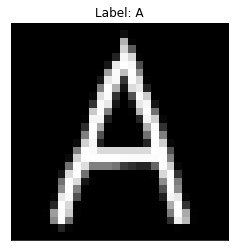

In [395]:
idx = 0
print(df_labels.iloc[idx])
plot_emnist_image_by_idx(idx = idx, df_features = df_features)


# Data Reduction

## Uniform Manifold Approximation and Projection (UMAP)

Reduce the data down to 100 columns which will capture about 90-95% of the information while speeding up the run time. From previous work with this data set the UMAP reduction technique had the most separation and is what I will use to reduce/preprocess this dataset.

Apply UMAP to image dataset

In [396]:
umap_model = umap.UMAP(n_components=100, random_state = 3)
umap_model = umap_model.fit(df_features)
umap_fitted = umap_model.transform(df_features)
umap_fitted.shape

(2600, 100)

Plot the data using the first two components of the UMAP fitted data.

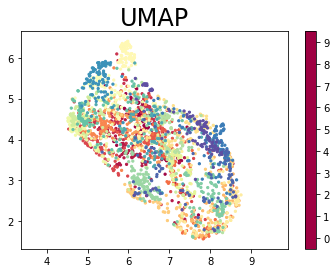

In [397]:
plt.scatter(umap_fitted[:, 0], umap_fitted[:, 1], s= 5, c=df_labels['label'].map(labels_dict_reversed), cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP', fontsize=24);

Save the ordinal features and update the features to be the reduced ones.

In [401]:
df_features_original = df_features.copy()
df_features = pd.DataFrame(umap_fitted)
df_features.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,7.185182,3.606289,5.362865,5.840247,7.453226,3.607499,8.105613,5.615936,5.606811,4.463170,5.268996,6.183116,3.890036,5.504498,4.331462,2.634963,5.172346,3.886459,4.812036,5.514788,3.732816,5.830236,4.449092,4.071497,2.759881,4.704540,5.152747,4.742552,4.120115,5.607279,5.275767,5.430853,5.091730,4.634233,4.639055,4.533196,4.855010,4.593903,4.736841,4.314534,...,5.870656,3.801789,4.781290,5.933755,4.969872,7.307757,4.358011,4.715189,5.568298,6.033731,5.196794,4.683832,5.023990,5.107673,5.323195,5.306134,4.642100,3.646848,5.224270,6.150288,4.731622,5.228973,4.031315,5.891894,5.026829,5.156649,6.098043,5.040883,5.360343,4.248909,6.547519,5.684191,5.215985,5.830408,4.931591,7.178354,4.269628,4.954920,4.935712,4.743643
1,6.254177,4.898910,5.755785,5.390442,7.614872,3.138251,7.954989,5.527551,5.948588,4.502376,5.202785,6.271161,3.978351,5.347538,4.682009,2.539710,5.342409,3.694661,4.672607,5.496978,3.698822,5.739990,4.238768,3.960038,2.747535,4.696168,5.287100,4.729759,4.133199,5.420434,5.337319,5.404862,5.045880,4.991095,4.391196,4.475754,4.784397,4.659338,4.859806,4.397702,...,6.011288,3.681080,4.651429,5.899705,4.796694,7.401474,4.193929,4.817808,5.487175,6.091983,5.261256,4.650252,5.078653,5.019331,5.143333,5.203433,4.621757,3.586742,5.337954,6.190314,4.749120,5.208131,4.019226,5.782848,5.007174,5.137957,6.112782,5.140783,5.436519,4.359493,6.721016,5.788895,5.264839,5.865114,5.006689,7.182289,4.293230,5.122121,4.910213,4.812302
2,7.942462,1.809297,5.693624,6.713310,6.461090,4.576018,8.245862,5.216132,4.921800,4.472256,5.079776,5.911037,3.762887,5.490587,4.079948,2.711368,5.088319,4.107653,5.068091,5.313255,3.818480,5.771211,4.802326,4.083671,2.738188,4.709918,5.090091,4.594079,4.217080,5.670704,5.083241,5.488501,5.172731,4.297517,4.838427,4.734004,5.022881,4.575128,4.667206,4.182203,...,5.603981,3.992703,4.887430,5.899548,5.309867,7.184886,4.593929,4.666498,5.588961,5.994713,5.163369,4.677031,4.795810,5.134394,5.537549,5.442891,4.697749,3.836316,5.173416,6.047207,4.667846,5.237530,3.988629,6.058379,5.124163,5.186688,6.089855,4.970739,5.301285,4.138559,6.363461,5.598592,5.158869,5.791121,4.839086,7.245524,4.231586,4.936001,4.988636,4.806703


In [402]:
df_labels.head(3)

,label
0,A
1,A
2,A


Create numpy version of the features and labels for ease of use with future steps.

In [403]:
np_features = df_features.to_numpy()
np_labels = df_labels.to_numpy().reshape(1,-1)[0]

# Locality Sensitive Hashing (LHS)

Apply LHS to the reduced letter data.

Import the Fiass Library

In [404]:
!apt install libomp-dev
!python -m pip install --upgrade faiss faiss-gpu
# Note needed to set an older version of faiss-gpu for it to run in Colab
!python -m pip install --upgrade faiss-gpu==1.7.1


# Clear output for this cell
from IPython.display import clear_output
clear_output()

In [405]:
import faiss # !pip show faiss-gpu

Define the FAISS Qunatizer and Index

In [406]:
quantizer_lhs = faiss.IndexFlatL2(np_features.shape[1])
index_lhs = faiss.IndexIVFPQ(quantizer_lhs,
                         np_features.shape[1], 
                         100,             # number_of_partition,
                         10,              # search_in_x_partitions, 
                         5)               # subvector_size

Build the index

In [407]:
index_lhs.train(np_features)
index_lhs.add(np_features)

Search for similar item based on the first item in the dataset.

In [408]:
# Pass in the first three features labeled with A's
search_vector_lhs = np_features[0:1]
distances_lhs, indices_lhs = index_lhs.search(x = search_vector_lhs,k = 5)

In [409]:
indices_lhs[0]

array([   0, 1016,   61,   94,   80])

In [410]:
print(f"The most similar letter images to {np_labels[0]} are:\n")
print([np_labels[i] for i in indices_lhs[0]])

The most similar letter images to A are:

['A', 'K', 'A', 'A', 'A']


Display search result indicies for reference and latter plotting

In [411]:
indices_lhs[0]

array([   0, 1016,   61,   94,   80])

# Exhaustive Search

Summarize details of the data

In [412]:
faiss.MatrixStats(np_features).comments.split("\n")

['analyzing 2600 vectors of size 100',
 'no NaN or Infs in data',
 'all vectors are distinct',
 'range of L2 norms=[50.3579, 51.2249] (0 null vectors)',
 'matrix contains no 0s',
 'no constant dimensions',
 'no dimension has a too large mean',
 'stddevs per dimension are in [0.0251787 1.12453]',
 '']

Create a Faiss Index

In [413]:
# Flatten the features and add them to the index
index_es = faiss.IndexFlatL2(np_features.shape[1])
index_es.add(np_features)

In [414]:
# Pass in the first three features labeled with A's
search_vector_es = np_features[0:1]
distances_es, indices_es = index_es.search(x = search_vector_es,k = 5)

In [415]:
indices_es[0]

array([   0,   80,   61, 1016,   94])

In [416]:
print(f"The most similar letter images to {np_labels[0]} are:\n")
print([np_labels[i] for i in indices_es[0]])

The most similar letter images to A are:

['A', 'A', 'A', 'K', 'A']


The initial results of this are great since all of the similar items found are all showing 'A' labels. While testing out other parameters like just one search vector, similar labels such as F and P showed up.

# Product Quantization

When applying Product Quantization the parameters are very dataset dependant and need adjustment to fit the data. For example this notebook used 100 columns as reduced data from the original image with 728 column image data and so the number of partitions and the sub vectors need to be multiples of the total number of columns and made small enough to fit into the 8 bit representation.

In [417]:
quantizer_pq = faiss.IndexFlatL2(np_features.shape[1])
index_pq = faiss.IndexIVFPQ(quantizer_pq,
                         np_features.shape[1], 
                         100,             # number_of_partition,
                         10,               # search_in_x_partitions, 
                         5)               # subvector_size

Fit the index

In [418]:
index_pq.train(np_features)
index_pq.add(np_features)

Search the vector

In [419]:
search_vector_pq = np_features[0:1]
distances_pq, indices_pq = index_pq.search(x = search_vector_pq, k = 5)

Display results

In [420]:
indices_pq[0]

array([   0, 1016,   61,   94,   80])

In [421]:
%%time
print(f"The most similar letter images to {np_labels[0]} are:\n")
print([np_labels[i] for i in indices_pq[0]])

The most similar letter images to A are:

['A', 'K', 'A', 'A', 'A']
CPU times: user 0 ns, sys: 492 µs, total: 492 µs
Wall time: 383 µs


The results of the Product Quantization search are very similar to the full FAISS exhaustive search. I noticed that in different runs the were some different indices in the Quantized search results and this is because it is just an approximate search and also the UMAP dimensionality reduction could be different in various fittings.

# Trees and Graphs

For tree based search we will apply the Annoy method on the reduced image data

In [422]:
!pip install annoy

# Clear output for this cell
from IPython.display import clear_output
clear_output()

In [423]:
import annoy

Define the index. Reference tutorial [Trees and Forests](https://github.com/eyaltrabelsi/my-notebooks/blob/master/Lectures/search_in_practice-approximate_nearest_neighbors/Trees%20and%20Forrests.ipynb)

In [424]:
index_tg =  annoy.AnnoyIndex(np_features.shape[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  """Entry point for launching an IPython kernel.


Build the index

In [425]:
# Add each vector to the index one at a time
for i, vec in enumerate(np_features):
  index_tg.add_item(i, vec.tolist())

index_tg.build(n_trees = 5)

True

Search for similar item based on the first item in the dataset.

In [426]:
# Pass in the first three features labeled with A's
search_vector_tg = np_features[0:1].tolist()[0]
indices_tg = index_tg.get_nns_by_vector(vector = search_vector_tg,n = 5)

In [427]:
indices_tg

[0, 80, 61, 1016, 94]

In [428]:
print(f"The most similar letter images to {np_labels[0]} are:\n")
print([np_labels[i] for i in indices_tg])

The most similar letter images to A are:

['A', 'A', 'A', 'K', 'A']


These Annoy Tree search results are very similar to the exhaustive and product quantized search results.

# Hierarchical Navigable Small World Graphs (HNSW)

For the HNSW search method we will use nmslib

In [429]:
!pip install nmslib

# Clear output for this cell
from IPython.display import clear_output
clear_output()

In [430]:
import nmslib

Define the index

In [431]:
index_hnsw = nmslib.init(method='hnsw', space='cosinesimil')

Train the index on the image data

In [432]:
index_hnsw.addDataPointBatch(np_features)
index_hnsw.createIndex({'post': 2})

Search for similar item based on the first item in the dataset.

In [433]:
# Pass in the first feature labeled with an A
search_vector_hnsw = np_features[0:1]
indices_hnsw = index_hnsw.knnQuery(vector = search_vector_hnsw, k = 5)

In [434]:
indices_hnsw[0]

array([   0,   80,   61, 1016,   94], dtype=int32)

In [435]:
print(f"The most similar letter images to {np_labels[0]} are:\n")
print([np_labels[i] for i in indices_hnsw[0]])

The most similar letter images to A are:

['A', 'A', 'A', 'K', 'A']


Again the search results are very similar to other methods shown above.

# Summary of Results

While testing different random states on the data sampling and also the UMAP dimensionality reduction some of Approximate search methods had differing results. For this example all search methods had the same results but in different orders.

Create a table of summary search results from each method and sort them for easier visibility.

In [436]:
# Dictionary of search results
results_dict = {'LHS' :  np.sort(indices_lhs[0]),
    'Exhaustive': np.sort(indices_es[0]),
    'Product Quantization' : np.sort(indices_pq[0]),
    'Trees and Graphs' : np.sort(np.array(indices_tg)),
    'HNSW' : np.sort(indices_hnsw[0]),
 }

df_results = pd.DataFrame(results_dict)
df_results

,LHS,Exhaustive,Product Quantization,Trees and Graphs,HNSW
0,0,0,0,0,0
1,61,61,61,61,61
2,80,80,80,80,80
3,94,94,94,94,94
4,1016,1016,1016,1016,1016


One interesting result was that each of the various search methods found one wrong label (namely the "K" at index 1016). To visually see why lets plot out the various images.

Plot of original search image/vector:

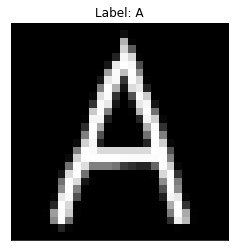

In [437]:
idx = 0
plot_emnist_image_by_idx(idx = idx, df_features = df_features_original)

Plot the 5 images returned from the search results

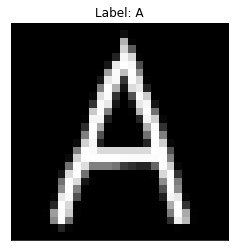

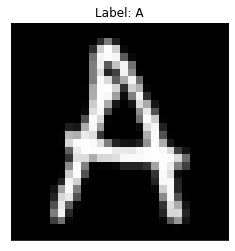

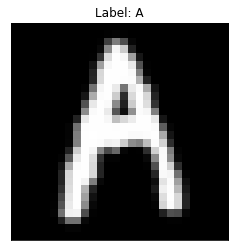

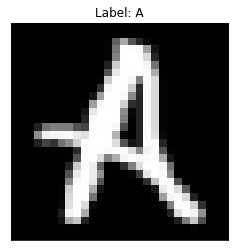

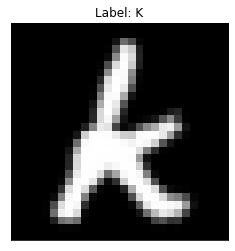

In [438]:
for result in np.sort(indices_lhs[0]):
  plot_emnist_image_by_idx(idx = result, df_features = df_features_original)

After reviewing the image from the mislabeled "K" it's easy to see how this particular image could be similar to a capital A which was the ordinal search vector of each method.